# Notebook Title: Data Insights from Cleaning Audits – A Strategic Approach Using Data Science

# 0. Introduction: What is Data Science?

# 0.1 **Data Science** is the field that uses scientific methods, algorithms, and systems to extract insights and value from data. 

In a business context, it empowers decision-making by transforming raw data into actionable intelligence.

Despite the perception that large volumes of data are required, even small datasets can reveal operational inefficiencies and opportunities for improvement.

This project demonstrates how **data from cleaning audits**, even if limited, can drive **strategic insights** that support our company’s goals, enhance client satisfaction, and strengthen performance accountability.


# 1.0. Library

## 1.1. Imports 

In [251]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates

import re
import calendar


from datetime          import datetime
from scipy.stats       import linregress
from matplotlib.ticker import PercentFormatter




## 1.1.2 Visual Settings

In [252]:
# Set a modern and clear visual style  
plt.style.use('seaborn-v0_8')  

# Graphics style
sns.set(style='whitegrid', palette='husl', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

# 2.0 Load and Clean Excel 

In [253]:
def load_clean_sheet(filepath, sheet_name):
    df = pd.read_excel(filepath, sheet_name=sheet_name)
    df.columns = df.columns.str.strip().str.replace(' +', ' ', regex=True)
    df.columns = df.columns.str.replace('Questionarie Result', 'Questionnaire Result', regex=False)
    
    expected_cols = [
        'Date Completed', 'Site', 'Answered by',
        'Percentage Received', 'Score', 'Questionnaire Result',
        'Yes', 'No', 'N/A'
    ]
    if not set(expected_cols).issubset(df.columns):
        missing = list(set(expected_cols) - set(df.columns))
        raise ValueError(f"Missing columns in sheet '{sheet_name}': {missing}")
    
    return df

# 3. Load all monthly sheets

In [254]:
file_path = "audits.xlsx"
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names
all_data = {sheet: load_clean_sheet(file_path, sheet) for sheet in sheet_names}
df_all = pd.concat(all_data.values(), ignore_index=True)

# 4.0  Data enrichment

In [255]:
df_all['Date Completed'] = pd.to_datetime(df_all['Date Completed'], errors='coerce')
df_all['Month'] = df_all['Date Completed'].dt.month.apply(
    lambda x: calendar.month_abbr[x] if pd.notnull(x) else None
)
df_all['Valid Questions'] = df_all['Yes'] + df_all['No']
df_all['Calculated Score'] = np.where(
    df_all['Valid Questions'] > 0,
    (df_all['Yes'] / df_all['Valid Questions']) * 100,
    np.nan
)

# 5.0 Score classification function

In [243]:
# Score classification function
def classify_score(score):
    if pd.isnull(score):
        return 'Not Applicable'
    elif score >= 80:
        return 'Approved'
    elif score >= 60:
        return 'Acceptable'
    else:
        return 'Critical'


# 6.0 Evaluation (adjusting for buildings with too few questions)

In [244]:
#  Evaluation (adjusting for buildings with too few questions)
df_all['Evaluation'] = df_all['Calculated Score'].apply(classify_score)
df_all['Evaluation Adjusted'] = df_all.apply(
    lambda row: 'Not Enough Data' if row['Valid Questions'] <= 5 else classify_score(row['Calculated Score']),
    axis=1
)

# 7.0 Barplot - Top 10 and Bottom 10 Site

/var/folders/vp/z0zsw7sd3z1g0l663x5px37r0000gn/T/ipykernel_89874/2771398132.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=filtered_sites, x='Calculated Score', y='Site', palette='RdYlGn_r')


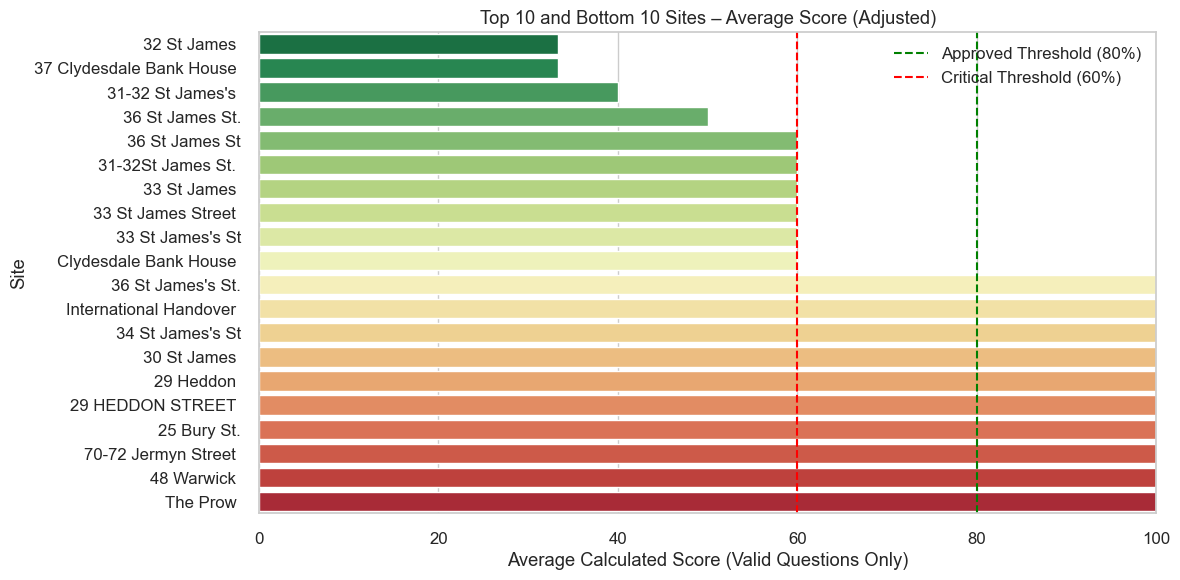

In [245]:
# Barplot - Top 10 and Bottom 10 Sites
avg_scores_by_site = df_all.groupby('Site')['Calculated Score'].mean().sort_values().reset_index().dropna()
top_10 = avg_scores_by_site.tail(10)
bottom_10 = avg_scores_by_site.head(10)
filtered_sites = pd.concat([bottom_10, top_10])

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_sites, x='Calculated Score', y='Site', palette='RdYlGn_r')
plt.axvline(80, color='green', linestyle='--', label='Approved Threshold (80%)')
plt.axvline(60, color='red', linestyle='--', label='Critical Threshold (60%)')
plt.xlabel('Average Calculated Score (Valid Questions Only)')
plt.ylabel('Site')
plt.title('Top 10 and Bottom 10 Sites – Average Score (Adjusted)')
plt.xlim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()



# 8.0 Heatmap - Site vs Month

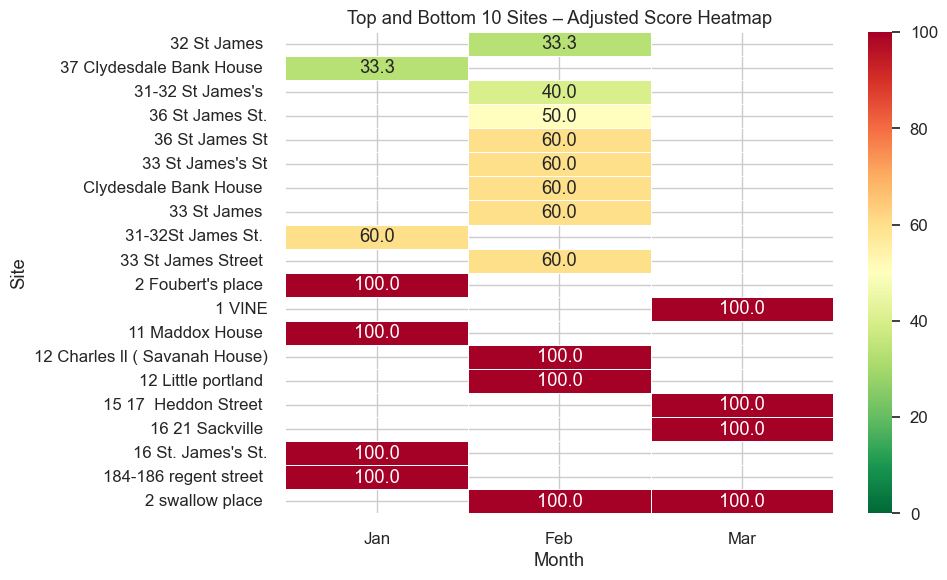

In [246]:
# Generate average score per site
avg_score_per_site = df_all.groupby("Site")["Calculated Score"].mean()

# Identify top and bottom 10
bottom_10_sites = avg_score_per_site.nsmallest(10).index.tolist()
top_10_sites = avg_score_per_site.nlargest(10).index.tolist()
filtered_sites = bottom_10_sites + top_10_sites

# Filter data
df_filtered = df_all[df_all['Site'].isin(filtered_sites)]

# Pivot table with only filtered sites
filtered_score_pivot = df_filtered.pivot_table(
    values='Calculated Score',
    index='Site',
    columns='Month',
    aggfunc='mean'
)

# Reorder columns and rows
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
existing_months = [m for m in month_order if m in filtered_score_pivot.columns]
filtered_score_pivot = filtered_score_pivot.reindex(columns=existing_months)

filtered_score_pivot = filtered_score_pivot.reindex(
    avg_score_per_site.loc[filtered_sites].sort_values().index
)

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    filtered_score_pivot,
    cmap='RdYlGn_r',
    annot=True,
    fmt='.1f',
    vmin=0,
    vmax=100,
    linewidths=0.5
)
plt.title('Top and Bottom 10 Sites – Adjusted Score Heatmap')
plt.xlabel('Month')
plt.ylabel('Site')
plt.tight_layout()
plt.show()


# 9.0 Scatter Plot – Relationship Between Percentage Received and Score

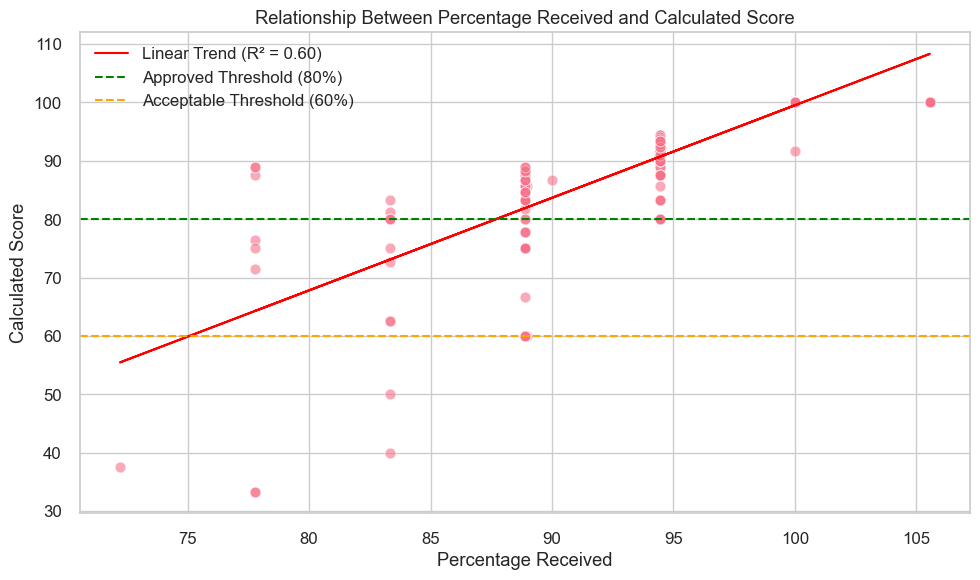

In [247]:
# Prepare variables
x = df_all['Percentage Received']
y = df_all['Calculated Score']

# Linear regression calculation
slope, intercept, r_value, p_value, std_err = linregress(x, y)
regression_line = slope * x + intercept

# Enhanced scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, alpha=0.6, s=60)
plt.plot(x, regression_line, color='red', label=f'Linear Trend (R² = {r_value**2:.2f})')
plt.axhline(80, color='green', linestyle='--', label='Approved Threshold (80%)')
plt.axhline(60, color='orange', linestyle='--', label='Acceptable Threshold (60%)')
plt.xlabel('Percentage Received')
plt.ylabel('Calculated Score')
plt.title('Relationship Between Percentage Received and Calculated Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 10. Define Fact and Dimension

In [248]:
#  Define Fact and Dimension
fact_columns = ['Calculated Score']
dim_columns = ['Date Completed', 'Month', 'Site', 'Answered by', 'Percentage Received', 'Questionnaire Result']

print("Fact columns:", fact_columns)
print("Dimension columns:", dim_columns)

Fact columns: ['Calculated Score']
Dimension columns: ['Date Completed', 'Month', 'Site', 'Answered by', 'Percentage Received', 'Questionnaire Result']


# 11. Executive Summary

In [249]:
print("Executive Summary:")
print(f"• Total Audits: {len(df_all)}")
print(f"• Unique Sites: {df_all['Site'].nunique()}")
print("\n• Evaluation Distribution:")
print(df_all['Evaluation Adjusted'].value_counts().to_string())
print("\n• Top 5 Sites:")
print(df_all.groupby('Site')['Calculated Score'].mean().sort_values(ascending=False).head(5))
print("\n• Bottom 5 Sites:")
print(df_all.groupby('Site')['Calculated Score'].mean().sort_values().head(5))

Executive Summary:
• Total Audits: 271
• Unique Sites: 190

• Evaluation Distribution:
Evaluation Adjusted
Approved           234
Acceptable          19
Not Enough Data     14
Critical             4

• Top 5 Sites:
Site
The Prow                          100.0
12 Charles ll ( Savanah House)    100.0
12 Little portland                100.0
5 Swallow                         100.0
49 Warwick Street                 100.0
Name: Calculated Score, dtype: float64

• Bottom 5 Sites:
Site
32 St James                  33.333333
37 Clydesdale Bank House     33.333333
31-32 St James's             40.000000
36 St James St.              50.000000
36 St James St               60.000000
Name: Calculated Score, dtype: float64


# 12. Export cleaned file

In [250]:
df_all.to_csv("cleaned_audit_data.csv", index=False)

# 🧼 Cleaning Audit Analysis – Executive Summary

## 📌 Context
This audit report summarises cleaning performance across multiple sites over the last few months. Each audit includes responses to up to 18 questions, completed by different auditors. This analysis was designed to identify performance trends, critical areas, and opportunities for operational improvement.

## 🧠 Objectives
- Monitor cleaning quality across key properties
- Identify critical underperforming sites
- Recognise top-performing buildings
- Provide a basis for quick strategic decision-making

## 📊 Key Insights

### ✅ Evaluation Distribution
- **Approved (≥80%)**: Majority of sites received satisfactory evaluations
- **Acceptable (60–79%)**: Some locations require minor adjustments
- **Critical (<60%)**: Few sites demand immediate action
- **Not Enough Data**: Sites with less than 5 valid questions excluded from evaluation

### 📈 Site Performance
- **Top 10 Sites** maintained consistently high scores above 90%
- **Bottom 10 Sites** scored below 60% and require review
- Results are visualised with bar plots and monthly heatmaps

### 🔍 Percentage Received vs Score
- A positive correlation suggests that better response rates tend to align with higher audit performance
- A linear regression line illustrates this relationship clearly

### 👥 Auditor Breakdown
- You can filter the dashboard to view **which buildings each auditor covered**
- Useful to balance workload and validate audit coverage

## 📦 Recommendations
- Focus attention on critical buildings listed in the bottom 10
- Reassign or train resources in low-performing areas
- Monitor buildings with incomplete questionnaires for potential structural issues
- Continue regular audits and track monthly progress

## 💡 Final Thoughts
Even with limited data, insightful performance indicators can be extracted to support fast and confident decision-making.


# 🧼 Análise de Auditoria de Limpeza – Resumo Executivo

## 📌 Contexto
Este relatório resume o desempenho de limpeza em diversos prédios ao longo dos últimos meses. Cada auditoria inclui até 18 perguntas respondidas por diferentes auditores. A análise foi construída para identificar tendências, áreas críticas e oportunidades de melhoria.

## 🧠 Objetivos
- Monitorar a qualidade da limpeza nos principais imóveis
- Identificar locais com baixo desempenho
- Reconhecer os prédios com melhor avaliação
- Oferecer subsídios para decisões estratégicas rápidas

## 📊 Principais Insights

### ✅ Distribuição das Avaliações
- **Aprovado (≥80%)**: Maioria dos locais com avaliação satisfatória
- **Aceitável (60–79%)**: Alguns precisam de ajustes pontuais
- **Crítico (<60%)**: Requerem atenção imediata
- **Poucos Dados**: Sites com menos de 5 perguntas válidas foram desconsiderados da avaliação

### 📈 Desempenho por Site
- Os **10 melhores sites** mantêm desempenho acima de 90%
- Os **10 piores sites** têm score abaixo de 60%
- Gráficos de barras e heatmaps mensais facilitam a visualização

### 🔍 Relação entre % Recebida e Score
- Correlação positiva indica que melhor taxa de resposta tende a gerar melhor performance
- Uma linha de tendência linear foi aplicada para evidenciar essa relação

### 👥 Auditor por Site
- O dashboard permite visualizar **quais prédios cada auditor avaliou**
- Útil para equilibrar a carga de trabalho e validar cobertura das auditorias

## 📦 Recomendações
- Direcionar atenção aos prédios críticos listados
- Reforçar ou treinar equipes nos locais de menor desempenho
- Acompanhar prédios com formulários incompletos
- Continuar as auditorias regulares e monitorar a evolução mês a mês

## 💡 Considerações Finais
Mesmo com dados limitados, é possível gerar indicadores úteis para apoiar decisões rápidas e eficazes.


Cleaning Audit Analysis – Mind Map
├── 📌 Context
│   └── Multiple monthly audit sheets, each with up to 18 questions
│
├── ❓ Key Business Questions
│   ├── Which sites perform best/worst?
│   ├── Which audits need attention?
│   ├── Are auditors consistently covering all sites?
│   └── Can we find patterns in response % and score?
│
├── 🧠 Hypotheses
│   ├── Sites with lower valid questions may score poorly by bias
│   ├── Auditors may have uneven workload
│   ├── Response rates positively impact audit scores
│   └── Seasonal or monthly trends exist in performance
│
├── 🧮 Data Structuring
│   ├── ✅ Fact Columns
│   │   └── Calculated Score, Percentage Received
│   └── 📊 Dimension Columns
│       ├── Site
│       ├── Date Completed / Month
│       ├── Answered by
│       └── Questionnaire Result
│
├── 📈 Metrics & Transformations
│   ├── Valid Questions = Yes + No
│   ├── Calculated Score = Yes / Valid Questions
│   └── Evaluation (Adjusted):
│       ├── Approved: ≥80%
│       ├── Acceptable: 60–79%
│       ├── Critical: <60%
│       └── Not Enough Data: ≤5 valid questions
│
├── 📊 Visualisations
│   ├── Barplot – Top/Bottom 10 Sites
│   ├── Heatmap – Score by Month & Site
│   ├── Scatter – % Received vs Score + Trend Line
│   ├── Summary Metrics – Audit Count, Sites, Evaluation Dist.
│   └── Auditor Coverage – Sites per Auditor
│
└── 📦 Actions & Recommendations
    ├── Focus on critical sites for improvement
    ├── Rebalance auditor coverage if needed
    ├── Improve response rate strategies
    └── Track results monthly with same framework
